# $\mathrm{HONO}$

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "HONO" 
nice_name = "HONO"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 403.93913
min λ: 184.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

10544


4×7 DataFrame
 Row │ variable   mean           min           median         max         nmis ⋯
     │ Symbol     Float64        Real          Float64        Real        Int6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          347.453        184.0         349.651        401.423          ⋯
   2 │ σ            9.53908e-20    6.5563e-24    6.51245e-20    4.25e-18
   3 │ T          297.984        295.0         298.0          300.0
   4 │ source_id   16.7276         1            22.0           28
                                                               2 columns omitted

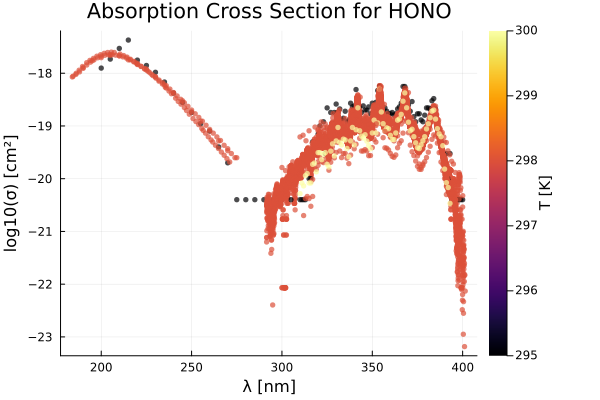

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

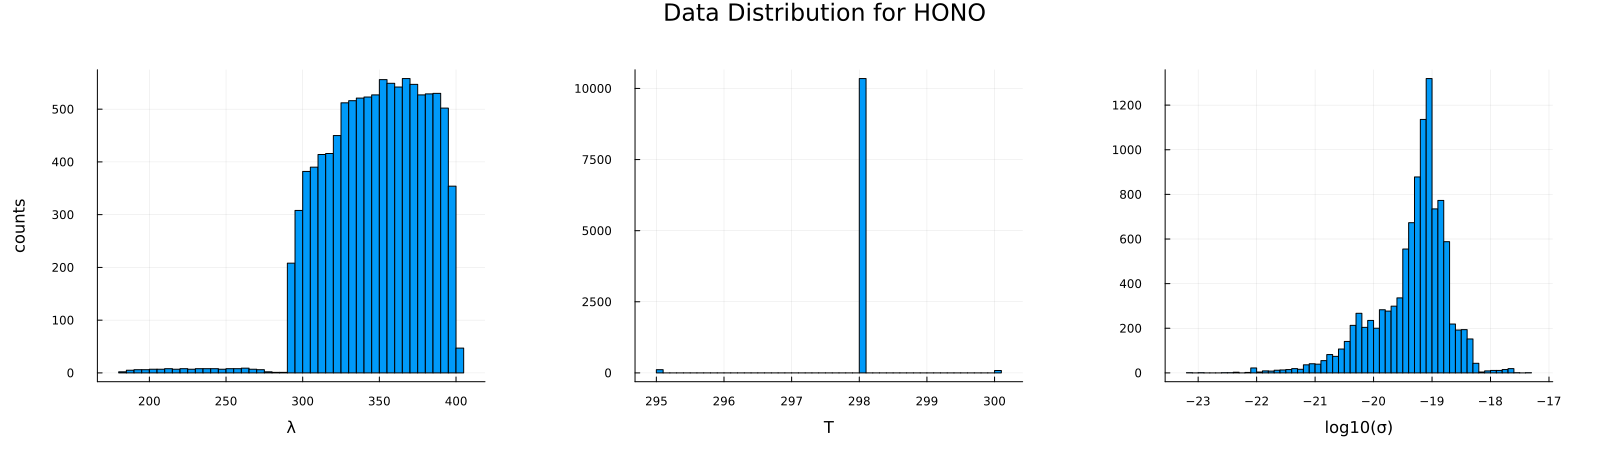

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

# Data Preprocessing

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

8955×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │   200.0  1.25e-18     295.0
    2 │   205.0  1.85e-18     295.0
    3 │   210.0  2.95e-18     295.0
    4 │   215.0  4.25e-18     295.0
    5 │   220.0  1.77e-18     295.0
    6 │   225.0  1.4e-18      295.0
    7 │   230.0  1.04e-18     295.0
    8 │   235.0  6.8e-19      295.0
    9 │   240.0  4.2e-19      295.0
   10 │   245.0  2.8e-19      295.0
   11 │   250.0  1.8e-19      295.0
  ⋮   │    ⋮         ⋮         ⋮
 8946 │   384.0  1.993e-19    300.0
 8947 │   385.0  1.351e-19    300.0
 8948 │   386.0  8.87e-20     300.0
 8949 │   387.0  7.09e-20     300.0
 8950 │   388.0  6.25e-20     300.0
 8951 │   389.0  4.22e-20     300.0
 8952 │   390.0  1.52e-20     300.0
 8953 │   391.0  8.4e-21      300.0
 8954 │   392.0  6.8e-21      300.0
 8955 │   393.0  3.4e-21      300.0
                   8934 rows omitted

In [10]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
λ_idxs = representative_rand_sample(df_unique.λ, 500, 1500)
T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

1878


3×7 DataFrame
 Row │ variable  mean           min           median         max         nmiss ⋯
     │ Symbol    Float64        Float64       Float64        Float64     Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         338.913        184.0         342.08         401.423           ⋯
   2 │ σ           1.25769e-19    6.5563e-24    4.07075e-20    4.25e-18
   3 │ T         297.955        295.0         298.0          300.0
                                                               2 columns omitted

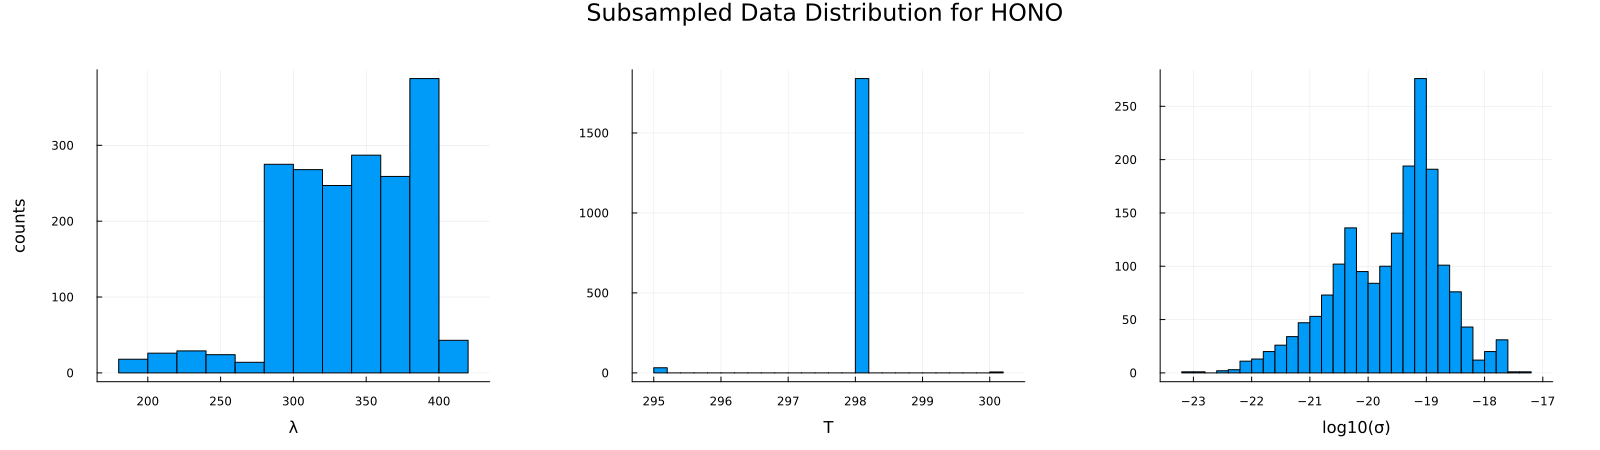

In [11]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

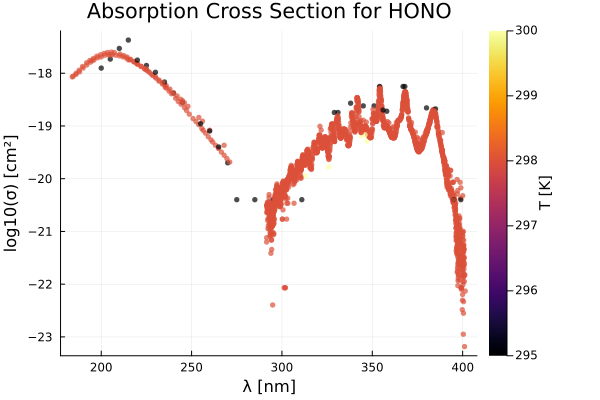

In [30]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [31]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1784


In [32]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

94-element Vector{Float64}:
 -19.198287659519412
 -19.863913902615902
 -18.491093382744047
 -19.33315455011595
 -20.395061510800065
 -20.230128096286425
 -19.289214352749866
 -20.159260498557767
 -19.43098912965265
 -18.167491087293765
 -18.824285292691304
 -18.891367334419524
 -19.266931195881398
   ⋮
 -20.97608939364908
 -20.41164984704618
 -18.36022474116076
 -17.872895201635192
 -19.26121944151563
 -17.747146969020108
 -21.87308970539984
 -19.990634101653754
 -17.657577319177793
 -18.901217875685308
 -19.19143795108335
 -18.024568191490737

In [33]:
# compute length scales
κ = 0.5 
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [34]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)


GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.1681829078355351, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.4961606404915395, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.213923017446879, exp, 1.4901161193847656e-8)), 
  σ² = 0.0338079696754227, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [35]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     2.665050e+03     2.562300e+03
 * time: 0.00015616416931152344
     1     1.216115e+03     6.443656e+02
 * time: 6.895938158035278
     2     6.100956e+02     3.344758e+02
 * time: 8.453816175460815
     3     4.540864e+02     1.724311e+02
 * time: 9.490594148635864
     4     3.904122e+02     2.416873e+02
 * time: 12.547337055206299
     5     3.160481e+02     1.448952e+02
 * time: 14.108402967453003
     6     2.869712e+02     4.652883e+01
 * time: 15.680535078048706
     7     2.577308e+02     5.165339e+01
 * time: 17.77608013153076
     8     2.278850e+01     1.835654e+02
 * time: 19.98371696472168
     9     8.793745e+00     1.226183e+02
 * time: 21.193228006362915
    10    -3.164512e+01     5.324095e+01
 * time: 23.092777967453003
    11    -4.737312e+01     3.417816e+01
 * time: 24.813135147094727
    12    -5.080487e+01     2.187292e+01
 * time: 26.464611053466797
    13    -6.557403e+01     1.068775e+02
 * time: 28.0741450786

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @887 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @665 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [36]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.958137258827238, 1.8105343745724463, 4.416096368178721, -3.175610507825261],
 minimum = -82.8245246305521,
 iterations = 1000,
 converged = false,)

In [37]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


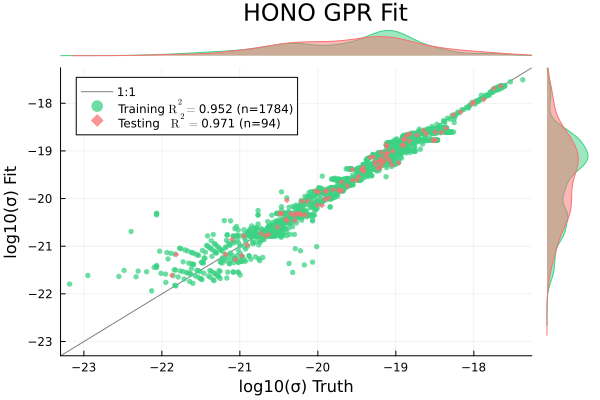

In [38]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

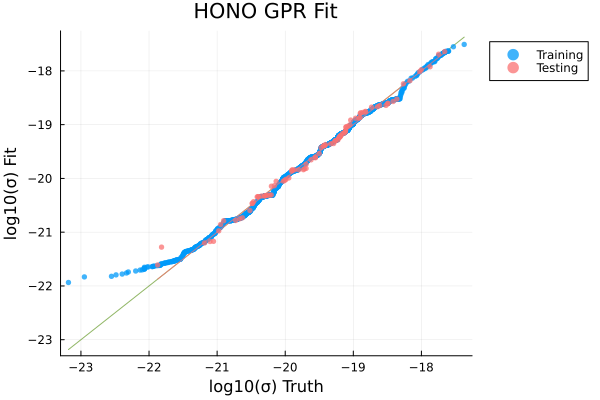

In [39]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


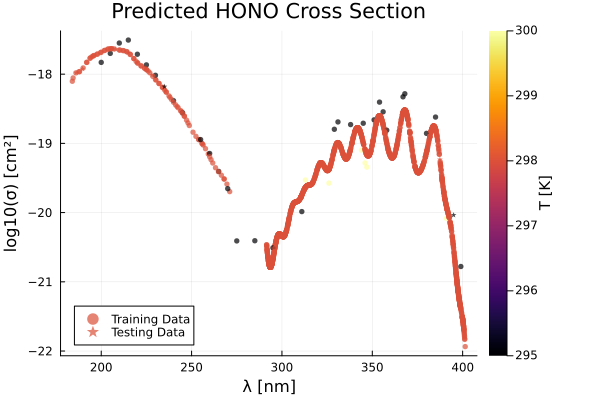

In [40]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

194.249
401.4227


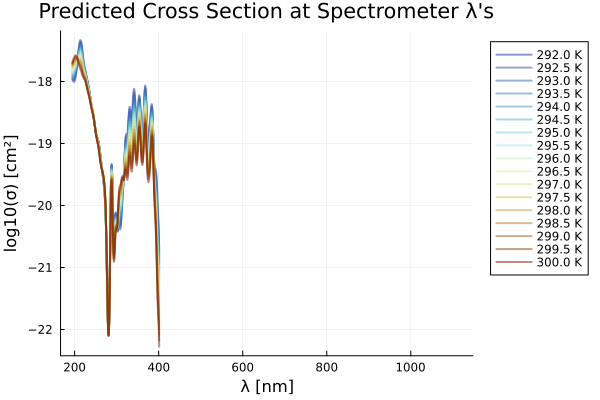

In [41]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

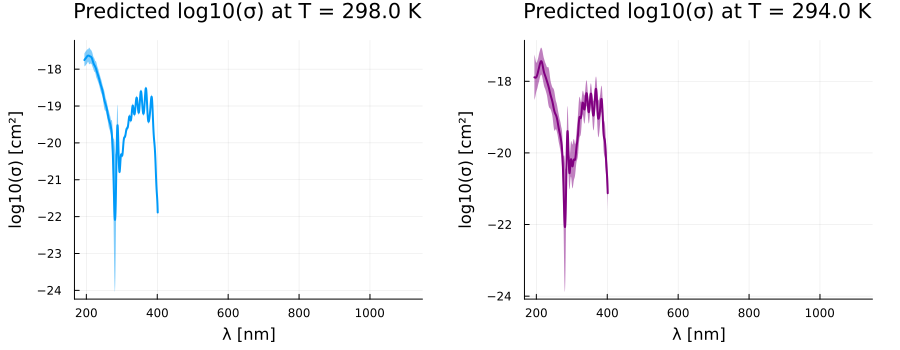

In [42]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [43]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

8×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.44881e-20    0.0      0.0             2.33958e-18
                                                               2 columns omitted

In [44]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

184.0	194.249
401.4227	1120.216


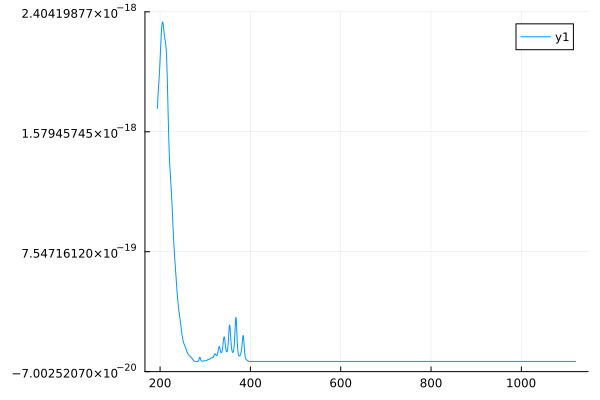

In [45]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [46]:
df_photolysis_σ.σ_7 = σ

describe(df_photolysis_σ)

8×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.4788e-20     0.0      0.0             2.33417e-18
                                                               2 columns omitted

In [47]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"